In [ ]:
import pandas as pd
import json

# Scraping functions
from scripts.hn_scrape import main
from scripts.metafilter_scrape import scrape_metafilter
from scripts.reddit_scrape import collect_reddit_data

# EDA
from utils.initial_eda import initial_eda, save_eda_report
from IPython.display import Image

# Preprocessing functions
from utils.metafilter_date_convert import convert
from utils.preprocessing_script import preprocess_text
from utils.pretrain_script import train_prep
from utils.self_labeling import get_match, get_label

# Load data from HuggingFace
from datasets import load_dataset

# Scrape Data

- Data was collected from our sources typically in two parts, first the main posts were collected using our given constraints, and then the comments were pulled from those posts

In [ ]:
main_meta, comments_meta = scrape_metafilter(pages=6)
main_hn, comments_hn = main(pages=30, per_page=30)
r_main, r_comments = collect_reddit_data(subreddit='politics', limit=100, min_comments=10)

# Preprocessing
- Each site names data elements differently so columns are renamed for each source to align with each other
- The time format is slightly different for each site so that conversion into a consistent format happens here as well (%Y %m %d)

In [ ]:
# Metafilter doesn't have a timestamp for its comment data so a custom function needed to be setup to piece it together and make sure it aligned with the parent post

comments_meta = convert(main_df=main_meta, comments_df=comments_meta)

In [ ]:
main_hn.rename(columns={"story_id": "post_id", "author": "post_author"}, inplace=True)
comments_hn.rename(columns={"story_id": "post_id", "author": "username"}, inplace=True)


main_meta.rename(columns={"thread_link": "post_id", "title": "post_title", "date": "created_at", "op_user": "post_author"}, inplace=True)
comments_meta.rename(columns={"thread_link": "post_id"}, inplace=True)

In [ ]:
# Load column aligned data for initial EDA

meta_main = pd.read_csv('data/metafilter_main.csv', parse_dates=['created_at'])
meta_comments = pd.read_csv("data/metafilter_comments.csv", parse_dates=['created_at'])

hn_main = pd.read_csv("data/hn_main.csv", parse_dates=['created_at'])
hn_comments = pd.read_csv("data/hn_comments.csv", parse_dates=['created_at'])

reddit_main = pd.read_csv("data/reddit_main.csv", parse_dates=['created_at'])
reddit_comments = pd.read_csv("data/reddit_comments.csv", parse_dates=['created_at'])

yt_main = pd.read_csv("data/youtube_videos.csv", parse_dates=['created_at'])
yt_comments = pd.read_csv("data/youtube_comments.csv", parse_dates=['created_at'])

bluesky_main = pd.read_csv("data/bluesky_main.csv", parse_dates=['created_at'])
bluesky_comments = pd.read_csv("data/bluesky_comments.csv", parse_dates=['created_at'])

# Initial EDA

The initial round of EDA focuses on each source in isolation.  The full round of EDA can be found in the `eda_notebooks` directory while below are the most interesting findings

## Metafilter

In [ ]:
with open("eda_logs/Metafilter/Metafilter_20260209_133804_summary.json", "r", encoding='utf-8') as f:
    meta_json = json.load(f)

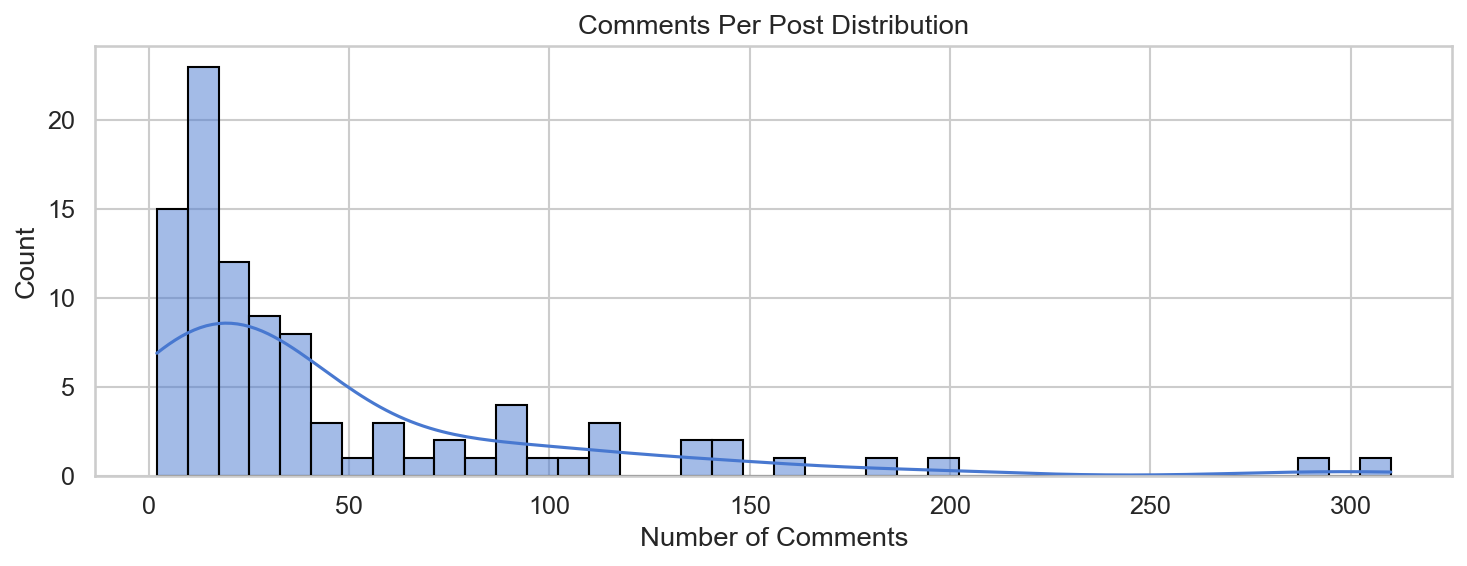

In [130]:
Image(filename="eda_logs/Metafilter/Metafilter_20260209_133804_comments_per_post.png", width=700)

Most posts from all sources followed a similar distribution with a heavy right-skewed distribution.  It would be interesting to see if there is any consistent patterns to the type of posts that get outlier sized engagement

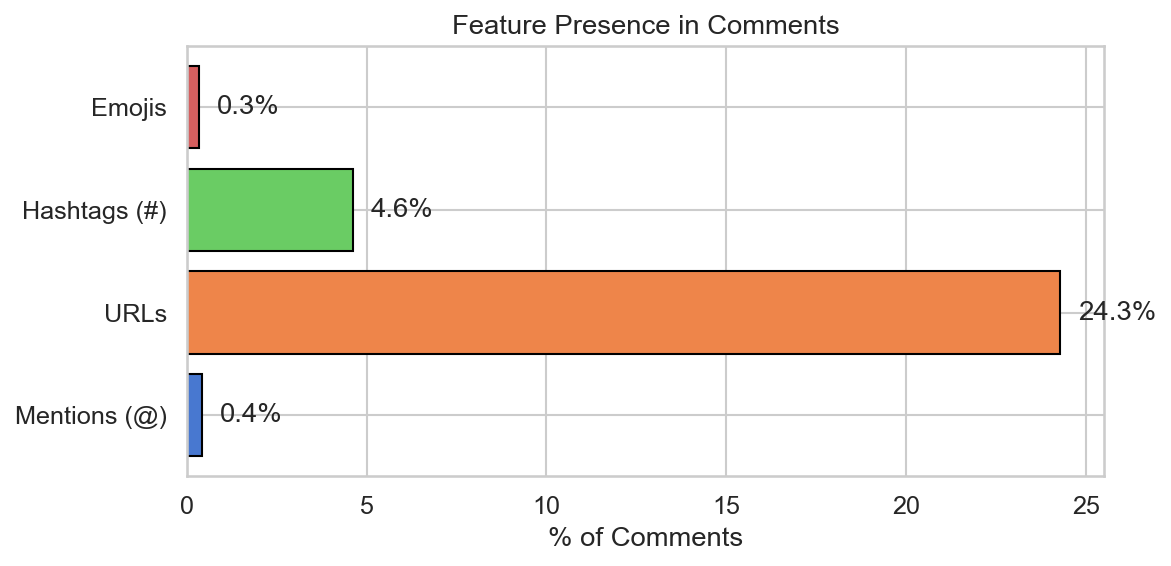

In [129]:
Image(filename="eda_logs/Metafilter/Metafilter_20260209_133804_feature_presence.png", width=700)

Metafilter has a high share of comments sharing url's, a signal that this forum has a trend of information sharing 

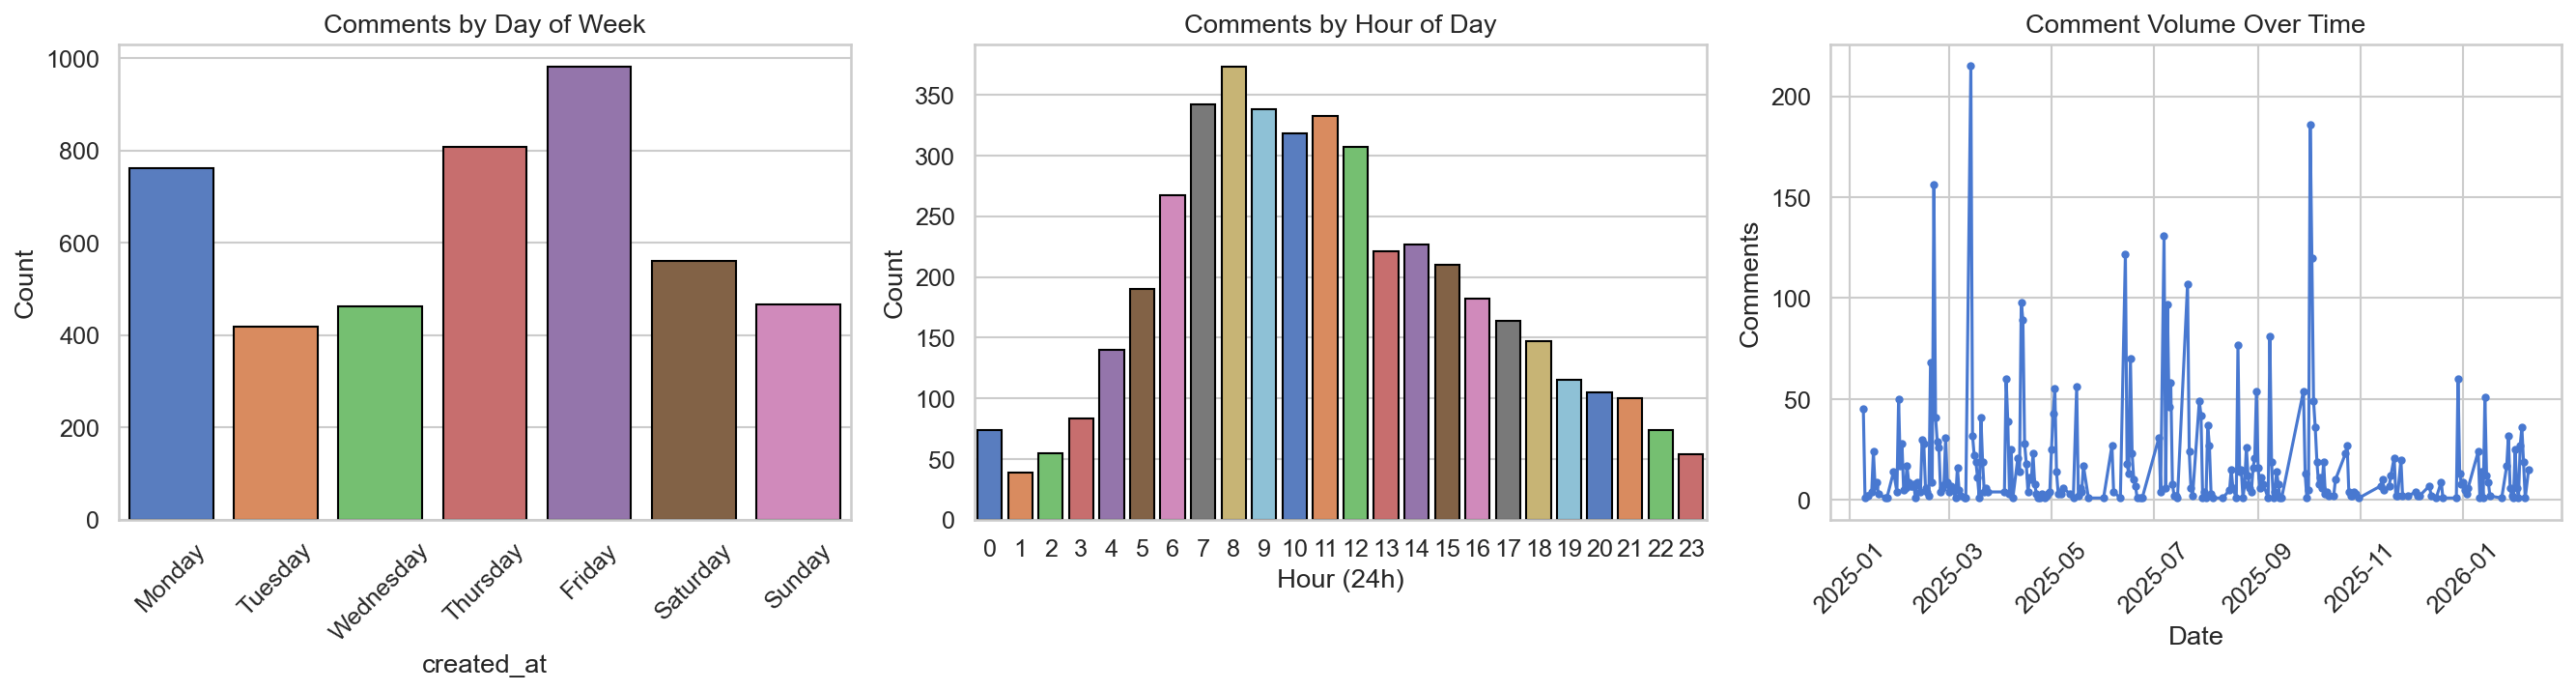

In [127]:
Image(filename="eda_logs/Metafilter/Metafilter_20260209_133804_temporal_patterns.png", width=900)

We see a roughly normal distribution with number of comments peaking between 7a and 9a UTC, and typically being posted by the end of the week.  The comment volume distribution over time has notable peaks, a reasonable assumption could be made that those coincide with news stories that received a lot of attention

## Hacker News

In [131]:
with open("eda_logs/Hacker News/Hacker News_20260209_150746_summary.json", "r", encoding='utf-8') as f:
    mhn_json = json.load(f)

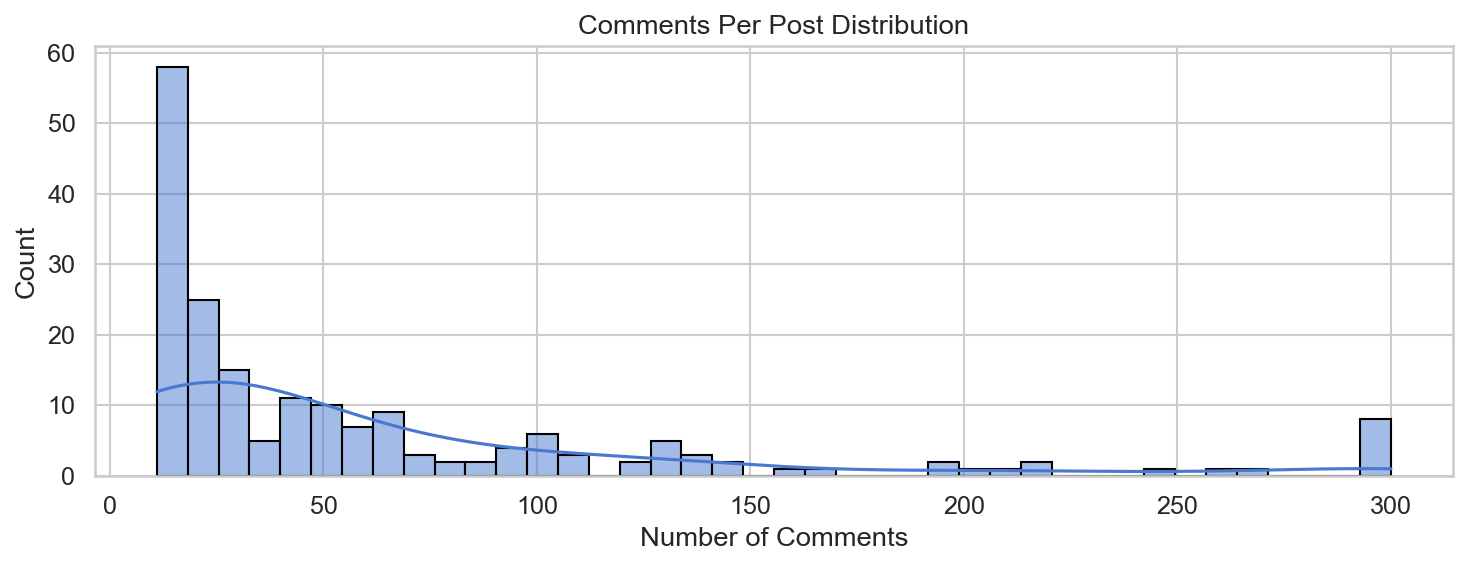

In [132]:
Image(filename="eda_logs/Hacker News/Hacker News_20260209_150746_comments_per_post.png", width=700)

Similar distribution with a starker right skew than Metafilter

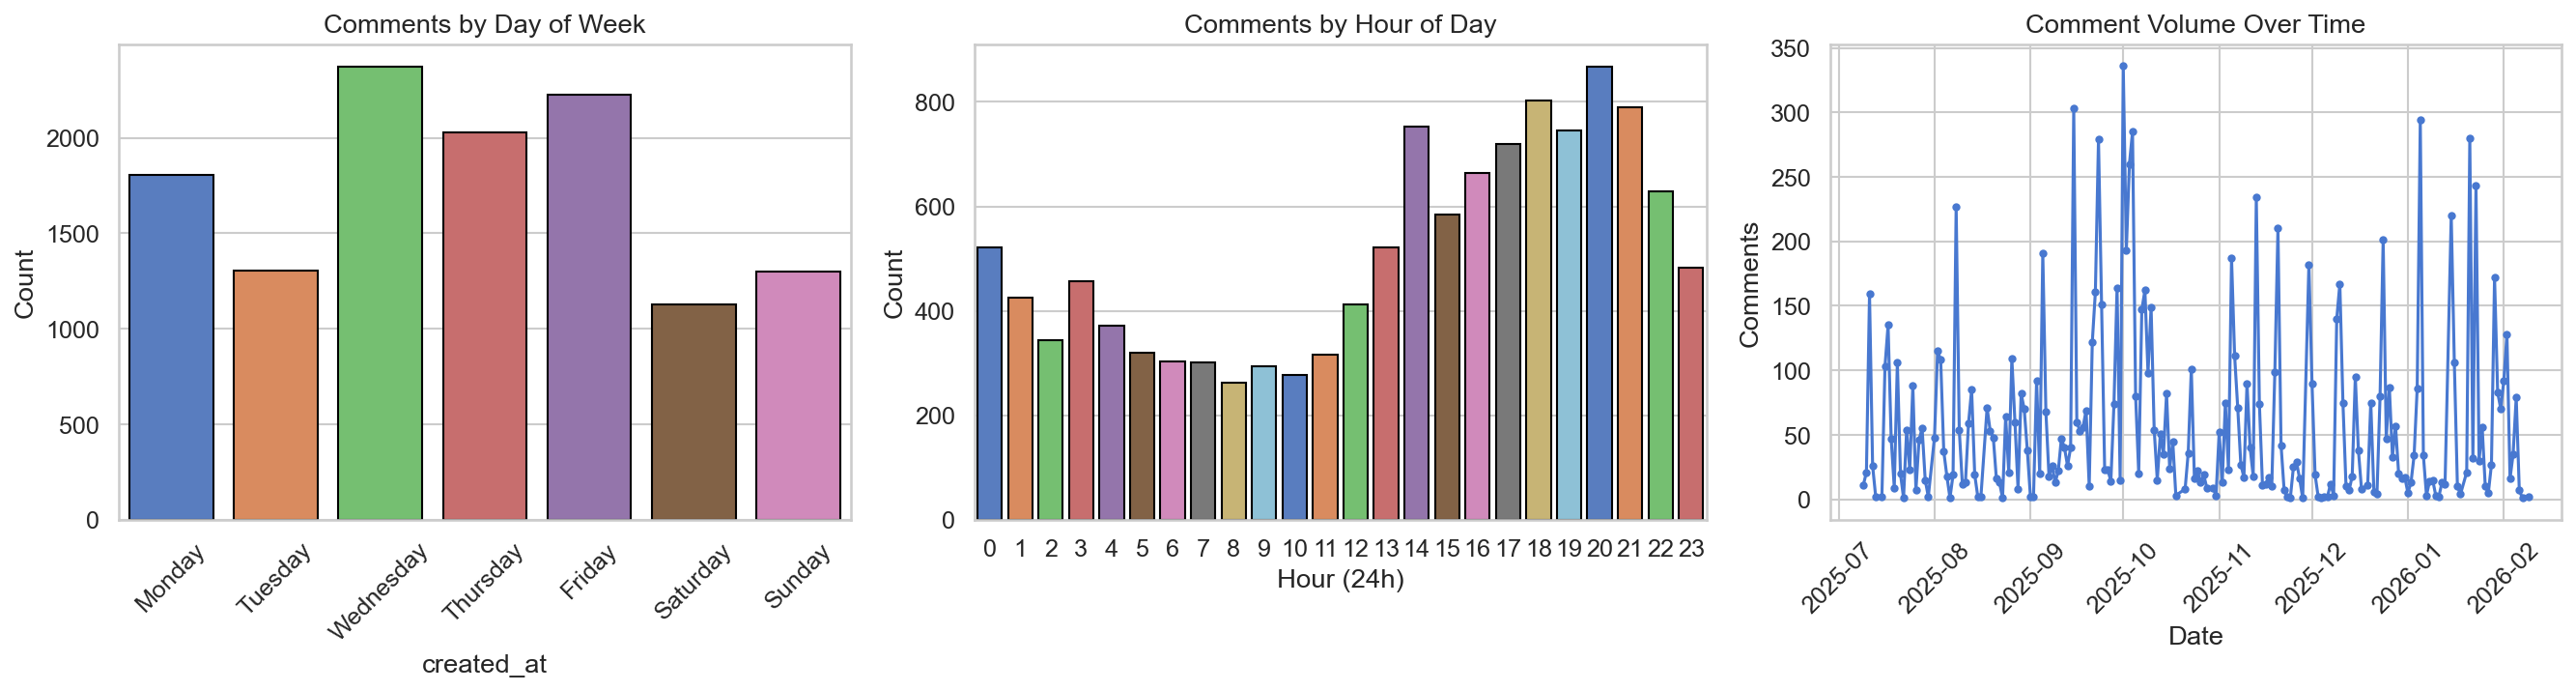

In [134]:
Image(filename="eda_logs/Hacker News/Hacker News_20260209_150746_temporal_patterns.png", width=900)

More activity in the middle of the week, and a left skewed distribution of comments over the course of the day.  Comment volume over time has several spikes, a signal that engagement to this site is driven by media stories.  

# Training Data Preprocessing

## Training Data for source labels

The preprocessing for the data follows two different paths for fine-tuning a transformer model and a logistic regression model that we use for our baseline

**Transformer Model**

We set the text to lower-case and remove or convert any leftover HTML tags and escaped elements.  To keep the presence of shared links without the noise, we place links with a 'URL' tag.  We then use the `emoji` package to turn emoji's into text

**Logistic Regression**

We perform the same steps as with the transformer data, while also removing stop words (using the `nltk` list), lemmatizing the text and removing all punctuation except for ? and !

In [ ]:
full_comments = pd.read_csv("data/full_comments.csv")
fine_tune_preprocess = full_comments.copy()
log_reg_preprocess = full_comments.copy()

In [ ]:
fine_tune_preprocess['comment_text'] = fine_tune_preprocess['comment_text'].apply(preprocess_text)
log_reg_preprocess['comment_text'] = log_reg_preprocess['comment_text'].apply(preprocess_text, args=({"full": True}))

In [22]:
fine_tune_preprocess.to_csv("data/fine_tune_data.csv", index=False)
log_reg_preprocess.to_csv("data/log_reg_data.csv", index=False)

## Training Data for Self-Labeling

We first labeled and fine-tuned a transformer model on 30k randomly sampled comments from our dataset.  The results were decent so we decided to fine-tune on all the comment data we had.  Below are the steps we took to concat the data

In [ ]:
# These two datasets are the full comments after using the Batch API for Gemini, Claude and GPT to label

initial_30k = pd.read_csv("data/self_labeling/initial_30k.csv")

ai_labels = pd.read_csv('data/self_labeling/remaining_ai_labeled_comments.csv')

In [85]:
df1 = initial_30k.loc[:, ['comment_text', 'source', 'label', 'openai_label', 'gemini_label']]
df1.rename(columns={"label": "claude_labels"}, inplace=True)

df2 = ai_labels.loc[:, ['comment_text', 'source', "claude_labels", 'openai_label', "gemini_label"]]

full_df = pd.concat([df1, df2])

In [ ]:
full_df['match'] = full_df.apply(get_match, axis=1)
subset = full_df[full_df['match'] == 'yes']

subset['true_label'] = subset.apply(get_label, axis=1)

subset['comment_text'] = subset['comment_text'].apply(preprocess_text)

final_df = subset[subset['true_label'] != 'nan']

The `get_match` function is used to label the records that had a majority vote.  Records with a 3-way tie were set aside.  The `get_label` method then applies the majority label vote, the text is preprocessed, then nan comments were removed

# Comparative EDA

# Prep Data For Fine-Tuning

The processed datasets were converted into HuggingFace datasets and pushed to our data repos for easier ingestion during fine-tuning and evaluation

In [23]:
dataset, label2id, id2label = train_prep(df=fine_tune_preprocess, test1=0.3, test2=0.5) 

In [ ]:
dataset.push_to_hub(repo_id="ADS509/full_experiment_labels")

In [ ]:
from huggingface_hub import DatasetCard

card = DatasetCard.load("ADS509/full_experiment_labels")
card.data.label2id = label2id # type: ignore
card.data.id2label = id2label # type: ignore
card.push_to_hub("ADS509/full_experiment_labels")

# Baseline Training

Baseline training for logistic regression used the source of the data as labels

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [58]:
log_reg_data = pd.read_csv("data/log_reg_data.csv").dropna()

X = log_reg_data['comment_text']
y = log_reg_data['source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=509, stratify=y)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
log_reg = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',
    random_state=509)

log_reg.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",509
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term

In [62]:
y_pred = log_reg.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Blue Sky       0.44      0.51      0.47      3321
 Hacker News       0.62      0.68      0.65      3646
    You Tube       0.85      0.69      0.76     11830
  metafilter       0.45      0.61      0.52      1333
      reddit       0.41      0.51      0.46      3099

    accuracy                           0.63     23229
   macro avg       0.55      0.60      0.57     23229
weighted avg       0.67      0.63      0.65     23229



In [ ]:
import numpy as np

model = LogisticRegression(class_weight='balanced', random_state=509)

param_grid = [
    {
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'l1_ratio': [0],
        'C': [1e-3, 0.1, 1, 10, 100],
        'max_iter': range(100, 1001, 250),
    },
    {
        'solver': ['saga'],
        'l1_ratio': np.arange(0, 1.1, 0.1),
        'C': [1e-3, 0.1, 1, 10, 100],
        'max_iter': range(100, 1001, 250),
    }
]

halving_search = HalvingGridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=3,
    verbose=10,
    random_state=509
)

halving_search.fit(X_train_tfidf, y_train)

In [76]:
y_pred = halving_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Blue Sky       0.38      0.47      0.42      3321
 Hacker News       0.57      0.63      0.60      3646
    You Tube       0.84      0.65      0.73     11830
  metafilter       0.36      0.62      0.46      1333
      reddit       0.39      0.46      0.42      3099

    accuracy                           0.59     23229
   macro avg       0.51      0.57      0.53     23229
weighted avg       0.64      0.59      0.61     23229

